In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
import os

In [2]:
# Define the custom dataset
class CustomFlowerDataset(ImageFolder):
    def __init__(self, root_dir, transform=None):
        super(CustomFlowerDataset, self).__init__(root=root_dir, transform=transform)


In [3]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, weight_decay=1e-4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=dropout_rate)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(p=dropout_rate)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=dropout_rate)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

        # Weight Decay (L2 Regularization) for fully connected layers
        self.fc1.weight_decay = weight_decay
        self.fc2.weight_decay = weight_decay

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
# Load the custom dataset
flower_dataset = CustomFlowerDataset(root_dir='flower_photos', transform=transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(flower_dataset))
val_size = int(0.1 * len(flower_dataset))
test_size = len(flower_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(flower_dataset, [train_size, val_size, test_size])

In [7]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
# Initialize model, loss criterion, and optimizer
model = SimpleCNN(num_classes=len(flower_dataset.classes), dropout_rate=0.5, weight_decay=1e-4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Lists to store training and validation accuracy/loss
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

In [13]:
# Training loop
num_epochs = 5
print_interval = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = correct_val / total_val
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Print and optionally plot the results every few epochs
    if epoch % print_interval == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Training Loss: 1.5847, Training Accuracy: 0.2708, Validation Loss: 1.5570, Validation Accuracy: 0.2698
Epoch 2/5, Training Loss: 1.5526, Training Accuracy: 0.3001, Validation Loss: 1.3818, Validation Accuracy: 0.4305
Epoch 3/5, Training Loss: 1.4795, Training Accuracy: 0.3709, Validation Loss: 1.3868, Validation Accuracy: 0.4251
Epoch 4/5, Training Loss: 1.4381, Training Accuracy: 0.3856, Validation Loss: 1.3216, Validation Accuracy: 0.4659
Epoch 5/5, Training Loss: 1.3858, Training Accuracy: 0.4097, Validation Loss: 1.3374, Validation Accuracy: 0.4469


In [14]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 45.23%


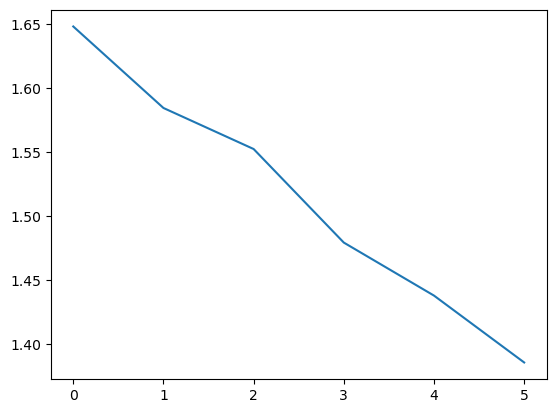

In [25]:
plt.plot(train_losses)

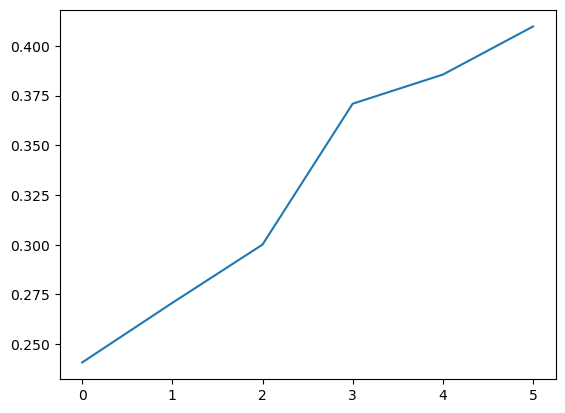

In [17]:
plt.plot(train_accuracies)

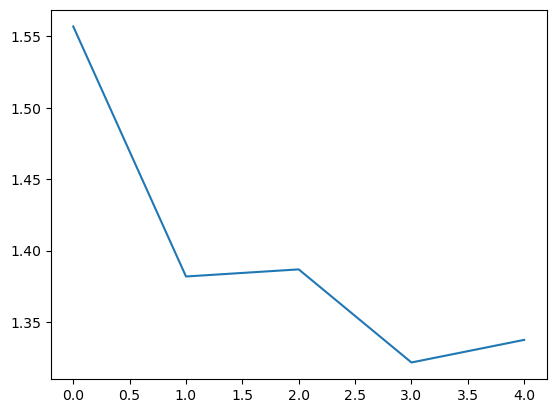

In [18]:
plt.plot(val_losses)

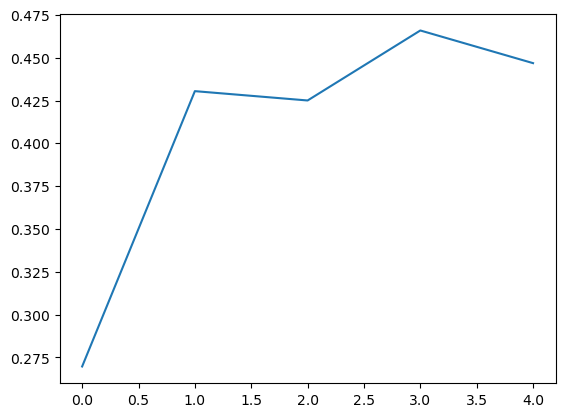

In [19]:
plt.plot(val_accuracies)